## DNN_for_textClassification 

In [9]:
# 根据影评判别电影当前用户对该电影的喜好

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.12.0
2.1.6-tf


In [2]:
imdb = keras.datasets.imdb
(train_data,train_label),(test_data,test_label) = imdb.load_data(num_words=10000)

In [3]:
# train_data[0] 数字，现将数字先转回评论文字
word_index = imdb.get_word_index()

word_index = { k:v+3 for k,v  in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(v,k) for (k,v) in word_index.items()])


def decode_text(text):
    return ' '.join([reverse_word_index.get(i,'?') for i in text])

### 准备数据 

In [4]:
# 将每条影评的词长度都扩充为256

train_data = keras.preprocessing.sequence.pad_sequences(train_data,value=word_index["<PAD>"],padding='post',maxlen=256)
test_data = keras.preprocessing.sequence.pad_sequences(test_data,value=word_index["<PAD>"],padding='post',maxlen=256)


### 构建模型 

In [10]:
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 训练目标
model.compile(optimizer=tf.train.AdamOptimizer(),
             loss = "binary_crossentropy",
             metrics=["accuracy"])

### 创建验证机 

In [14]:
# 测试集在模型训练和验证过程，最好只使用一次

x_val = train_data[:10000]
par_val = train_data[10000:]
x_label = train_label[:10000]
par_label = train_label[10000:]

### 训练模型 

In [15]:
# 数据量大，分批次(单次训练512个数据)，总计40回合
print(x_val.shape)
history = model.fit(par_val,
                    par_label,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, x_label),
                    verbose=1)

(10000, 256)
Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 2s 158us/step - loss: 0.6913 - acc: 0.5801 - val_loss: 0.6881 - val_acc: 0.6695
Epoch 2/40
15000/15000 [==============================] - 1s 80us/step - loss: 0.6827 - acc: 0.7240 - val_loss: 0.6769 - val_acc: 0.7286
Epoch 3/40
15000/15000 [==============================] - 1s 81us/step - loss: 0.6666 - acc: 0.7611 - val_loss: 0.6577 - val_acc: 0.7552
Epoch 4/40
15000/15000 [==============================] - 1s 83us/step - loss: 0.6403 - acc: 0.7695 - val_loss: 0.6294 - val_acc: 0.7739
Epoch 5/40
15000/15000 [==============================] - 1s 84us/step - loss: 0.6037 - acc: 0.8005 - val_loss: 0.5912 - val_acc: 0.7929
Epoch 6/40
15000/15000 [==============================] - 1s 83us/step - loss: 0.5594 - acc: 0.8183 - val_loss: 0.5491 - val_acc: 0.8066
Epoch 7/40
15000/15000 [==============================] - 1s 83us/step - loss: 0.5114 - acc: 0.8365 - val_loss: 0.

### 评估模型 

In [17]:
loss,acc = model.evaluate(test_data,test_label)
print(loss,acc)

25000/25000 [==============================] - 1s 24us/step
0.334717641658783 0.87252


### 创建准确率和损失随时间变化的图 

In [18]:
# model.fit() 返回一个 History 对象
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

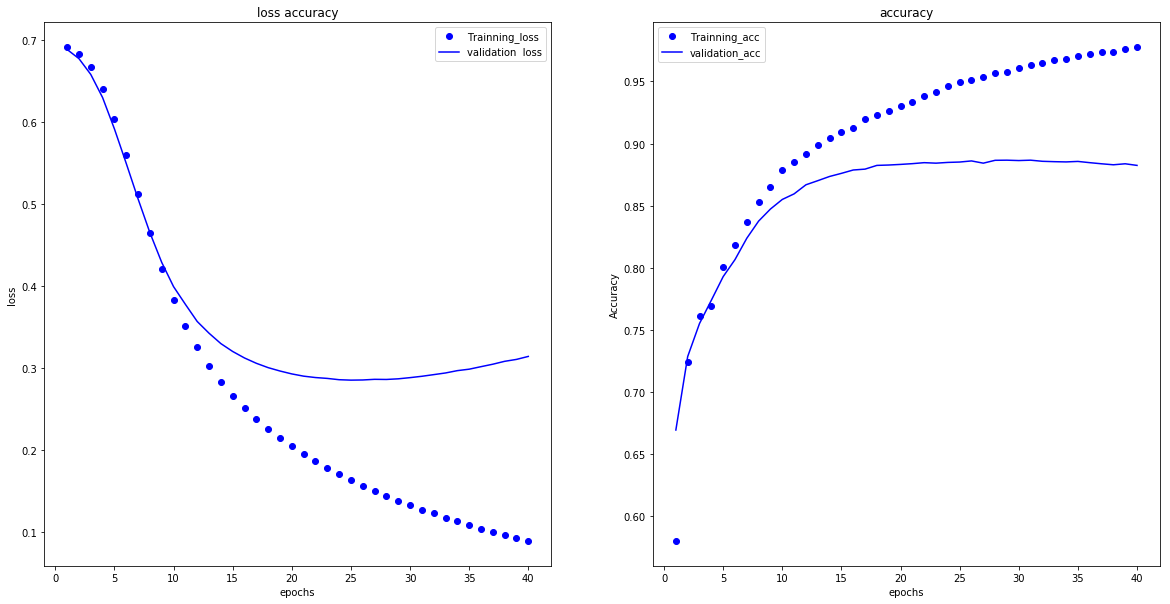

In [22]:
loss = history_dict['loss']
acc = history_dict['acc']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_acc']

epochs = range(1,len(loss)+1)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(epochs,loss,'bo',label="Trainning_loss")
plt.plot(epochs,val_loss,'b-',label="validation  loss")
plt.title("loss accuracy")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs,acc,'bo',label="Trainning_acc")
plt.plot(epochs,val_acc,'b-',label="validation_acc")
plt.title("accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

# 观察到 20 epochs 后，有点过拟合了